In [1]:
from scripts import bookdatafunctions as bdf
from scripts import corpusMLfunctions as cmf
import pandas as pd
import seaborn as sns
import matplotlib
import warnings
from tqdm import tqdm
from scipy.stats import bootstrap
from resample.bootstrap import resample
import numpy as np
from pprint import pprint
from time import perf_counter
warnings.filterwarnings('ignore')
import multiprocessing as mp
import matplotlib.pyplot as plt

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Constants

#Number of rounds to bootstrap
RUNS = 100

#Meaningful effect size for Cohen's d
MES = 0.79

#In how big a proportion do feats need to appear in to be considered consistant

CONSISTANT = 0.90

ISBN2AGE_PATH = "ISBN_MAPS/ISBN2AGE.xlsx"

In [3]:
#Nab corpus and transform ages
corpus = bdf.mapGroup2Age(bdf.initBooksFromConllus("Conllus"), ISBN2AGE_PATH)

In [4]:
#Define sub-corpora
"""
ages = sorted(bdf.getAvailableAges(corpus))
#Generate correct keys/ids
group_1 = [5,6,7,8]
group_2 = [9,10,11,12]
group_3 = [a for a in ages if a>12]
#Distinct subcorpora
sub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])
sub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])
sub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])
sub_corps = dict(zip(['7-8','9-12','13+'],[sub_corp_1, sub_corp_2, sub_corp_3]))
"""

"\nages = sorted(bdf.getAvailableAges(corpus))\n#Generate correct keys/ids\ngroup_1 = [5,6,7,8]\ngroup_2 = [9,10,11,12]\ngroup_3 = [a for a in ages if a>12]\n#Distinct subcorpora\nsub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])\nsub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])\nsub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])\nsub_corps = dict(zip(['7-8','9-12','13+'],[sub_corp_1, sub_corp_2, sub_corp_3]))\n"

In [5]:
#Prep feature amounts etc. to hopefully speed up calculations
#Old, non-parallelized version
"""
#Data structure will be dict[num,dict[id,dict[feat,value]]]
sub_corps_values = {'7-8':{}, '9-12':{}, '13+':{}}
index_dict = {}
for sub_corp in sub_corps:
    sub_corp_values = {}
    for book in sub_corps[sub_corp]:
        #If first book, then initialize index_dict that maps indices to features
        if len(index_dict) == 0:
            feat_vector, index_dict = cmf.customConlluVectorizer(sub_corps[sub_corp][book], True)
        #If index_dict already exists, then just fill out the feature vector
        else:
            feat_vector = cmf.customConlluVectorizer(sub_corps[sub_corp][book])
        #Generate a dictionary that has feature names as keys and feature values as values
        book_values = {index_dict[x]:feat_vector[x] for x in index_dict}
        #Save to sub_corp's dict
        sub_corp_values[book] = book_values
        #Save to sub_corps' dict
    sub_corps_values[sub_corp] = sub_corp_values
"""

"\n#Data structure will be dict[num,dict[id,dict[feat,value]]]\nsub_corps_values = {'7-8':{}, '9-12':{}, '13+':{}}\nindex_dict = {}\nfor sub_corp in sub_corps:\n    sub_corp_values = {}\n    for book in sub_corps[sub_corp]:\n        #If first book, then initialize index_dict that maps indices to features\n        if len(index_dict) == 0:\n            feat_vector, index_dict = cmf.customConlluVectorizer(sub_corps[sub_corp][book], True)\n        #If index_dict already exists, then just fill out the feature vector\n        else:\n            feat_vector = cmf.customConlluVectorizer(sub_corps[sub_corp][book])\n        #Generate a dictionary that has feature names as keys and feature values as values\n        book_values = {index_dict[x]:feat_vector[x] for x in index_dict}\n        #Save to sub_corp's dict\n        sub_corp_values[book] = book_values\n        #Save to sub_corps' dict\n    sub_corps_values[sub_corp] = sub_corp_values\n"

In [6]:
def processBookAndAddToDict(passed_data):
    book_id, book_data = passed_data
    feat_vector = cmf.customConlluVectorizer(book_data)
    return (book_id, feat_vector)

In [7]:
#List of items so that we can use map_async
corpus_items = list(corpus.items())

#Generate index dict
temp, index_dict = cmf.customConlluVectorizer(list(corpus.values())[0], True)



results = []
#Use multiprocessing to speed up vectorizing all books
with mp.Pool(mp.cpu_count()) as pool:
    with tqdm(total=len(corpus)) as pbar:
        def update(a):
            pbar.update()
        async_results = [pool.apply_async(processBookAndAddToDict, args=(item,), callback=update) for item in corpus_items]
        results = [async_result.get() for async_result in async_results]

100%|██████████| 300/300 [09:31<00:00,  1.91s/it]


## Code for checking correlations between variables

In [10]:
og_results = results.copy()

In [11]:
results = og_results


In [12]:
feat_dict = {index_dict[i]: i for i in index_dict}

In [13]:
print(feat_dict['ccomp'])

17


In [14]:
all_values = np.array([x[1] for x in results])

corr_coefs = np.nan_to_num(np.corrcoef(all_values, rowvar=False))

In [15]:
strongly_correlating = np.argwhere(corr_coefs[17]>0.9)
strongly_correlating = [index_dict[x[0]] for x in strongly_correlating]
print(strongly_correlating)

['mark', 'ccomp', 'SCONJ', 'tree_VERB_SCONJ']


<Axes: >

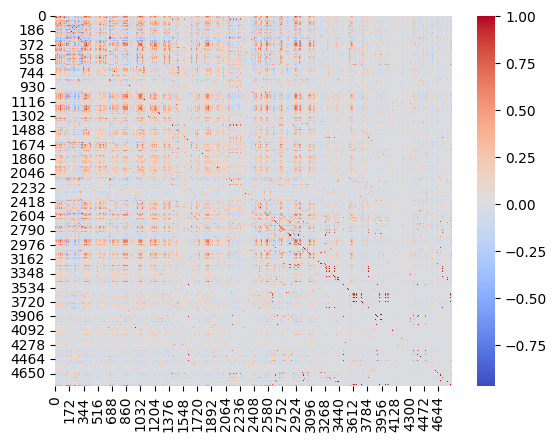

In [16]:
#Explodes if we try to include all features (inc. deprel bi- and trigrams)
sns.heatmap(corr_coefs, cmap='coolwarm')

<Axes: >

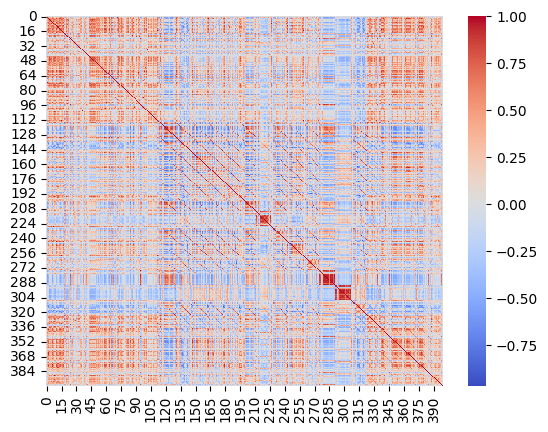

In [17]:
all_values_pinpoint = np.array([x[1][:400] for x in results])
pinpoint_corr_coefs = np.nan_to_num(np.corrcoef(all_values_pinpoint, rowvar=False))
sns.heatmap(pinpoint_corr_coefs, cmap='coolwarm')

### Checking if normalization affects results (it doesn't, so everything works as expected!)

In [18]:
def minMaxNormalization(min_vector: list, max_vector:list, feature_vector:list):
    """
    Helper function for performing min-max normalization for feature vectors
    """
    to_return = []
    for i in range(len(feature_vector)):
        min_max_neg = (max_vector[i]-min_vector[i])
        if min_max_neg == 0:
            to_return.append(0)
        else:
            to_return.append((feature_vector[i]-min_vector[i])/(max_vector[i]-min_vector[i]))
    return to_return


In [19]:
#Perform min-max standardization on the data
maxs = all_values.max(axis=0)
mins = all_values.min(axis=0)

scaled_rows = np.array([minMaxNormalization(mins, maxs, x) for x in all_values])

<Axes: >

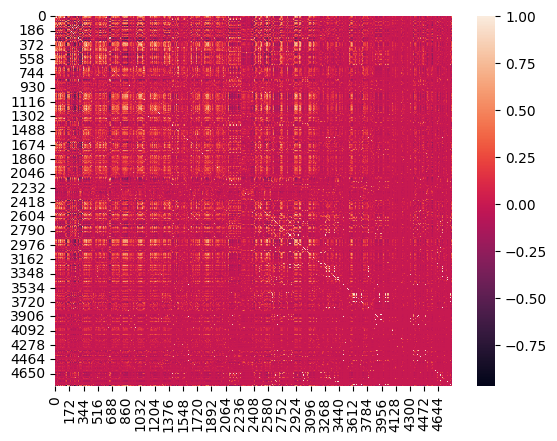

In [20]:
std_corr_coefs = np.nan_to_num(np.corrcoef(scaled_rows, rowvar=False))

sns.heatmap(std_corr_coefs)

## PCA testings

In [21]:

"""
#Safekeep original results so that we don't need to get them again if working on the notebook
og_results = results.copy()
#New results using scaled rows
new_results = [(results[i][0], scaled_rows[i]) for i in range(300)]
results = og_results
results = new_results
#PCA stuff from here
from sklearn.preprocessing import StandardScaler
#Instead of min-max norming, use SKLearn's StandardScaler
sklearn_scaled_rows = StandardScaler().fit_transform(all_values)
#Neat dataframe, works with SKLearn nicely
PCA_test_df = pd.DataFrame(data=sklearn_scaled_rows, columns=list(index_dict.values()), index=[x[0] for x in og_results])
from sklearn.decomposition import PCA
#Number of PCs
n = 250
#Perform PCA
pcs = PCA(n_components=n)
pcs.fit(PCA_test_df)
#What each PC "consists" of (aka how original features affect PCs)
loadings = pd.DataFrame(pcs.components_, columns=PCA_test_df.columns)
print(loadings)
#An example of the PC responsible for the most variance and which original features matter for it
print([loadings.columns[i[0]] for i in np.argwhere(loadings.iloc[0].to_numpy()>0.04)])

print('Explained variability per principal component: {}'.format(pcs.explained_variance_ratio_))

print("Total variance retained by ",n," components is: ",np.sum(pcs.explained_variance_ratio_))
#Plot for showing the variance ratio each PC brings to the table
explained_variance = pd.DataFrame(pcs.explained_variance_ratio_)#showing the first value
ax = explained_variance.head(n).plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()
#Use the trained 'model' to transform our original results with the features into ones using our PCs
tt = pcs.transform(all_values)

print(len(tt[0]))
#And this bit is here to make (most) of the code below this cell working as intended without needing any changes 
new_results = [(results[i][0], tt[i]) for i in range(300)]
results = new_results

og_index_dict = index_dict.copy()

index_dict = {x:"PC"+str(x) for x in range(n)}
feat_dict = {index_dict[i]: i for i in index_dict}
"""

'\n#Safekeep original results so that we don\'t need to get them again if working on the notebook\nog_results = results.copy()\n#New results using scaled rows\nnew_results = [(results[i][0], scaled_rows[i]) for i in range(300)]\nresults = og_results\nresults = new_results\n#PCA stuff from here\nfrom sklearn.preprocessing import StandardScaler\n#Instead of min-max norming, use SKLearn\'s StandardScaler\nsklearn_scaled_rows = StandardScaler().fit_transform(all_values)\n#Neat dataframe, works with SKLearn nicely\nPCA_test_df = pd.DataFrame(data=sklearn_scaled_rows, columns=list(index_dict.values()), index=[x[0] for x in og_results])\nfrom sklearn.decomposition import PCA\n#Number of PCs\nn = 250\n#Perform PCA\npcs = PCA(n_components=n)\npcs.fit(PCA_test_df)\n#What each PC "consists" of (aka how original features affect PCs)\nloadings = pd.DataFrame(pcs.components_, columns=PCA_test_df.columns)\nprint(loadings)\n#An example of the PC responsible for the most variance and which original fea

## Code for KFA

In [22]:
#Transforming list of items to dicts usable by the code below this block

#Number of bootstrap runs
#Adding this here again in case we want to do more runs inside the same notbook session without needing to wait for the original analysis on the books to be re-done
RUNS = 1000


#Defining subcorpora
ages = sorted(bdf.getAvailableAges(corpus))
#Generate correct keys/ids
group_1 = [5,6,7,8]
group_2 = [9,10,11,12]
group_3 = [a for a in ages if a>12]
#Distinct subcorpora
sub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])
sub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])
sub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])
sub_corps = dict(zip(['7-8','9-12','13+'],[sub_corp_1, sub_corp_2, sub_corp_3]))

#Values to a dictionary

sub_corps_values = {'7-8':{}, '9-12':{}, '13+':{}}

for id, data in results:
    age = int(bdf.findAgeFromID(id))
    if age < 9:
        sub_corps_values['7-8'][id] = {index_dict[x]:data[x] for x in index_dict}
    elif age < 13:
        sub_corps_values['9-12'][id] = {index_dict[x]:data[x] for x in index_dict}
    else:
        sub_corps_values['13+'][id] = {index_dict[x]:data[x] for x in index_dict}

In [23]:
#Using resample's bootstrapping method to gain lists of keys for each subcorp
bootstrapped_books = {j: [x for x in resample(list(sub_corps[j].keys()), size=RUNS)] for j in sub_corps}

In [24]:
#Some helper functions for this notebook
import math
def cohensdForValues(data1: list[float], data2: list[float]) -> float:
    #Sample size
    n1, n2 = len(data1), len(data2)
    #Variance
    s1, s2 = np.var(data1, ddof=1), np.var(data2, ddof=1)
    #Pooled standard deviation
    s = math.sqrt( ((n1-1)*s1 + (n2-1)*s2)/(n1+n2-2) )
    #Return Cohen's d
    return ((np.mean(data1)-np.mean(data2)) / s)

def valueListFromKeys(values, keys, feat):
    return [values[key][feat] for key in keys]

def sub_columns(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [25]:
#Old, non-parallelized implementation

effect_sizes_per_run = {}
with tqdm(range(RUNS), desc="Iterating over bootstrapped subcorpora...") as pbar:
    for i in range(RUNS):
        effect_sizes = {}
        for key1 in sub_corps:
            books_1 = bootstrapped_books[key1][i]
            values_1 = sub_corps_values[key1]
            for key2 in sub_corps:
                new_key = str(key1)+" vs. "+str(key2)
                #Skip if we already have the inverse
                if new_key in list(effect_sizes.keys()):
                    continue
                #If keys are the same, then d will be 0 always so save computing time
                if key1 == key2:
                    effect_sizes[new_key] = [0]*len(index_dict)
                    continue
                books_2 = bootstrapped_books[key2][i]
                values_2 = sub_corps_values[key2]
                #Oneliner that calculates Cohen's d for all feats between bootstrapped subcorps
                effect_sizes_temp = np.array([cohensdForValues(valueListFromKeys(values_1, books_1, index_dict[feat]), valueListFromKeys(values_2, books_2, index_dict[feat])) for feat in index_dict])
                effect_sizes[new_key] = effect_sizes_temp
                #Add the inverse to the dict
                new_key = str(key2)+" vs. "+str(key1)
                effect_sizes[new_key] = effect_sizes_temp * -1
        effect_sizes_per_run[i] = effect_sizes
        pbar.update(1)

Iterating over bootstrapped subcorpora...: 100%|██████████| 1000/1000 [18:45<00:00,  1.13s/it]


In [26]:
"""
def calcEffectSizes(run_number, sub_corps, bootstrapped_books, sub_corps_values, index_dict):
    effect_sizes = {}
    for key1 in sub_corps:
        books_1 = bootstrapped_books[key1][run_number]
        values_1 = sub_corps_values[key1]
        for key2 in sub_corps:
            new_key = str(key1)+" vs. "+str(key2)
            #Skip if we already have the inverse
            if new_key in list(effect_sizes.keys()):
                continue
            #If keys are the same, then d will be 0 always so save computing time
            if key1 == key2:
                effect_sizes[new_key] = [0]*len(index_dict)
                continue
            books_2 = bootstrapped_books[key2][run_number]
            values_2 = sub_corps_values[key2]
            #Oneliner that calculates Cohen's d for all feats between bootstrapped subcorps
            effect_sizes_temp = np.array([cohensdForValues(valueListFromKeys(values_1, books_1, index_dict[feat]), valueListFromKeys(values_2, books_2, index_dict[feat])) for feat in index_dict])
            effect_sizes[new_key] = effect_sizes_temp
            #Add the inverse to the dict
            new_key = str(key2)+" vs. "+str(key1)
            effect_sizes[new_key] = effect_sizes_temp * -1
    return (run_number, effect_sizes)
"""

'\ndef calcEffectSizes(run_number, sub_corps, bootstrapped_books, sub_corps_values, index_dict):\n    effect_sizes = {}\n    for key1 in sub_corps:\n        books_1 = bootstrapped_books[key1][run_number]\n        values_1 = sub_corps_values[key1]\n        for key2 in sub_corps:\n            new_key = str(key1)+" vs. "+str(key2)\n            #Skip if we already have the inverse\n            if new_key in list(effect_sizes.keys()):\n                continue\n            #If keys are the same, then d will be 0 always so save computing time\n            if key1 == key2:\n                effect_sizes[new_key] = [0]*len(index_dict)\n                continue\n            books_2 = bootstrapped_books[key2][run_number]\n            values_2 = sub_corps_values[key2]\n            #Oneliner that calculates Cohen\'s d for all feats between bootstrapped subcorps\n            effect_sizes_temp = np.array([cohensdForValues(valueListFromKeys(values_1, books_1, index_dict[feat]), valueListFromKeys(value

In [27]:
#Parallelized version of calculating effect sizes (KFA)
"""
e_s = []
#Use multiprocessing to speed up vectorizing all books
with mp.Pool(mp.cpu_count()-1) as pool:
    with tqdm(total=RUNS) as pbar:
        def update(a):
            pbar.update()
        async_results = [pool.apply_async(calcEffectSizes, args=(i, sub_corps, bootstrapped_books, sub_corps_values, index_dict), callback=update) for i in range(RUNS)]
        e_s = [async_result.get() for async_result in async_results]
#Combine results together
effect_sizes_per_run = {s[0]:s[1] for s in e_s}
"""

'\ne_s = []\n#Use multiprocessing to speed up vectorizing all books\nwith mp.Pool(mp.cpu_count()-1) as pool:\n    with tqdm(total=RUNS) as pbar:\n        def update(a):\n            pbar.update()\n        async_results = [pool.apply_async(calcEffectSizes, args=(i, sub_corps, bootstrapped_books, sub_corps_values, index_dict), callback=update) for i in range(RUNS)]\n        e_s = [async_result.get() for async_result in async_results]\n#Combine results together\neffect_sizes_per_run = {s[0]:s[1] for s in e_s}\n'

## Finding consistantly meaningful feats according to Cohen's d values over bootstrapped runs

In [236]:
strong_es = 0.8
med_es = 0.5
weak_es = 0.2
CONSISTANT = 0.99

In [237]:
#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeats(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    for corp in ef_sizes:
        y_1 = abs(np.nan_to_num(ef_sizes[corp]))
        for i in index_dict:
            if y_1[i]>=meaningful_ef_size:
                sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

In [238]:
meaningful_feats_strong = []
meaningful_feats_medium = []
meaningful_feats_weak = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        meaningful_feats_strong.append(meaningfulFeats(strong_es, effect_sizes_per_run[i]))
        meaningful_feats_medium.append(meaningfulFeats(med_es, effect_sizes_per_run[i]))
        meaningful_feats_weak.append(meaningfulFeats(weak_es, effect_sizes_per_run[i]))
        pbar.update(1)

Calculating meaningful effects per run...: 100%|██████████| 1000/1000 [00:38<00:00, 26.12it/s]


In [239]:
from collections import Counter
import itertools

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_strong))))
feat_counts_strong = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_strong))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_medium))))
feat_counts_medium = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_medium))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_weak))))
feat_counts_weak = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_weak))))

Strong ef size:  Counter({'AUX_Variation': 995, 'ADP_Variation': 978, 'flat_VERB_AUX_VERB': 955, 'StackingOfClauses': 946, 'NOUN_Variation_Corrected': 942, 'NestingOfClauses': 933, 'Reflex=Yes': 861, 'ccomp': 847, 'ADJ_Variation_Corrected': 837, 'VERB_Variation': 782, 'flat_AUX_VERB_VERB': 756, 'flat_PUNCT_PROPN_CCONJ': 745, 'Derivation=Ton': 726, 'ADV_Variation': 722, 'flat_PRON_PUNCT': 711, 'ADV_To_SCONJ_Ratio': 703, 'SCONJ_To_ADV_Ratio': 695, 'flat_INTJ_PUNCT_NOUN': 673, 'Number[psor]=Sing': 641, 'flat_PUNCT_PRON_INTJ': 631, 'PRON_Variation': 603, 'flat_VERB_PRON_PUNCT': 585, 'flat_SCONJ_AUX_VERB': 582, 'flat_AUX_PRON_PUNCT': 581, 'flat_PROPN_CCONJ_PROPN': 563, 'flat_NOUN_PUNCT_INTJ': 543, 'flat_AUX_AUX': 534, 'flat_SCONJ_AUX_AUX': 525, 'TTR': 507, 'tree_PRON_VERB_ADV': 499, 'SCONJ_Variation_Corrected': 497, 'Person[psor]=1': 487, 'flat_PRON_INTJ_PRON': 475, 'flat_PUNCT_SCONJ_AUX': 473, 'flat_AUX_AUX_VERB': 467, 'flat_AUX_AUX_PRON': 465, 'INTJ_To_SCONJ_Ratio': 462, 'flat_PRON_INTJ':

In [240]:
#In how big a proportion do feats need to appear in to be considered consistant

consistent_strong_feats = [feat for feat in feat_counts_strong if feat_counts_strong[feat]/RUNS > CONSISTANT]
consistent_medium_feats = [feat for feat in feat_counts_medium if feat_counts_medium[feat]/RUNS > CONSISTANT]
consistent_weak_feats = [feat for feat in feat_counts_weak if feat_counts_weak[feat]/RUNS > CONSISTANT]

In [241]:
"""
temp_dict = {}
for feat in consistent_strong_feats:
    es = []
    index = feat_dict[feat]
    for i in effect_sizes_per_run:
        e = effect_sizes_per_run[i]
        for j in e:
            if j not in ['7-8 vs. 7-8', '9-12 vs. 9-12', '13+ vs. 13+']:
                es.append(e[j][index])
    temp_dict[feat] = np.array(es)

sns.histplot(temp_dict, legend=False)
"""

"\ntemp_dict = {}\nfor feat in consistent_strong_feats:\n    es = []\n    index = feat_dict[feat]\n    for i in effect_sizes_per_run:\n        e = effect_sizes_per_run[i]\n        for j in e:\n            if j not in ['7-8 vs. 7-8', '9-12 vs. 9-12', '13+ vs. 13+']:\n                es.append(e[j][index])\n    temp_dict[feat] = np.array(es)\n\nsns.histplot(temp_dict, legend=False)\n"

In [242]:
print("Consistently at least strong features: ",consistent_strong_feats)
print("Consistently at least medium features: ",consistent_medium_feats)
print("Consistently at least weak features: ",consistent_weak_feats)

Consistently at least strong features:  ['AUX_Variation']
Consistently at least medium features:  ['ADJ_Variation_Corrected', 'flat_PUNCT_PRON_INTJ', 'SCONJ_Variation_Corrected', 'StackingOfClauses', 'ADP_Variation', 'flat_AUX_PRON_PUNCT', 'flat_INTJ_PUNCT_NOUN', 'PRON_Variation', 'AUX_Variation', 'VERB_Variation', 'Number[psor]=Sing', 'TTR', 'tree_PRON_VERB_ADV', 'flat_PRON_PUNCT', 'flat_PRON_INTJ', 'flat_SCONJ_AUX_VERB', 'Reflex=Yes', 'Derivation=Ton', 'ADV_Variation', 'NOUN_Variation_Corrected', 'flat_AUX_VERB_VERB', 'NestingOfClauses', 'ccomp', 'flat_PROPN_CCONJ_PROPN', 'SCONJ_To_ADV_Ratio', 'flat_VERB_AUX_VERB', 'ADV_To_SCONJ_Ratio', 'flat_PRON_INTJ_PRON', 'flat_PUNCT_PROPN_CCONJ']
Consistently at least weak features:  ['obj', 'PROPN_To_CCONJ_Ratio', 'INTJ_To_CCONJ_Ratio', 'flat_SCONJ_VERB_AUX', 'PROPN_To_AUX_Ratio', 'csubj', 'tree_VERB_PROPN_NOUN', 'SCONJ_Variation_Corrected', 'flat_PRON_PRON_ADP', 'StackingOfClauses', 'ADP_Variation', 'flat_VERB_PUNCT_INTJ', 'flat_INTJ_PUNCT_NOU

In [243]:
means = {}
for j in range(9):
    for i in effect_sizes_per_run:
        to_mean = []
        es = effect_sizes_per_run[i]
        to_mean.append(np.nan_to_num(np.array(list(es.values())[j])))
    means[list(es.keys())[j]] = np.median(to_mean, axis=0)

In [244]:
ef_df = pd.DataFrame(means, index=list(index_dict.values()))
testing_df = ef_df.copy()
print(len(testing_df))
#remove = ['root']
# ,
most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']

#Choose one of the ones below to use for the visualizations. Either Strong+, Medium+, or Weak+ feats

#most_important = consistent_strong_feats
most_important = consistent_medium_feats
#most_important = consistent_weak_feats
to_drop = [x for x in index_dict.values() if x not in most_important]
print(most_important)
testing_df_edited = testing_df.drop(to_drop)
print(len(testing_df_edited))

4810
['ADJ_Variation_Corrected', 'flat_PUNCT_PRON_INTJ', 'SCONJ_Variation_Corrected', 'StackingOfClauses', 'ADP_Variation', 'flat_AUX_PRON_PUNCT', 'flat_INTJ_PUNCT_NOUN', 'PRON_Variation', 'AUX_Variation', 'VERB_Variation', 'Number[psor]=Sing', 'TTR', 'tree_PRON_VERB_ADV', 'flat_PRON_PUNCT', 'flat_PRON_INTJ', 'flat_SCONJ_AUX_VERB', 'Reflex=Yes', 'Derivation=Ton', 'ADV_Variation', 'NOUN_Variation_Corrected', 'flat_AUX_VERB_VERB', 'NestingOfClauses', 'ccomp', 'flat_PROPN_CCONJ_PROPN', 'SCONJ_To_ADV_Ratio', 'flat_VERB_AUX_VERB', 'ADV_To_SCONJ_Ratio', 'flat_PRON_INTJ_PRON', 'flat_PUNCT_PROPN_CCONJ']
29


<Axes: >

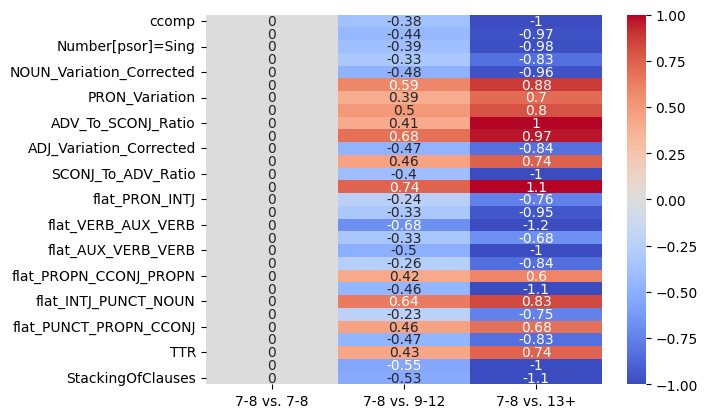

In [245]:
sns.heatmap(testing_df_edited[sub_columns(ef_df.columns, '7')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

## Plot KFA results distributions and compare with different feature sets

In [246]:
def plotKFAValuesDistribution(effect_sizes_per_run, chosen_comp, weak_feat_indices, medium_feat_indices, strong_feat_indices):
    """
    Helper function for plotting histogram distribution of KFA results.
    Optionally you can add a subset of features (their indices from index_dict) to e.g. only include features with consitently strong effects.
    The red lines mark the area where effect sizes are not significant
    """

    f, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True)

    all_vals = []
    weak_vals = []
    medium_vals = []
    strong_vals = []
    for i in effect_sizes_per_run:
            weak_vals += [effect_sizes_per_run[i][chosen_comp][j] for j in weak_feat_indices]
            medium_vals += [effect_sizes_per_run[i][chosen_comp][j] for j in medium_feat_indices]
            strong_vals += [effect_sizes_per_run[i][chosen_comp][j] for j in strong_feat_indices]
            all_vals += effect_sizes_per_run[i][chosen_comp].tolist()
    sns.histplot(all_vals, ax=axes[0])
    axes[0].set_title('All features')
    sns.histplot(weak_vals, ax=axes[3])
    axes[1].set_title('Weak+ features')
    sns.histplot(medium_vals, ax=axes[2])
    axes[2].set_title('Medium+ features')
    sns.histplot(strong_vals, ax=axes[1])
    axes[3].set_title('Strong+ features')
    #plt.axvline(weak_es, 0, 15000, color='r')
    #plt.axvline(-weak_es, 0, 15000, color='r')

In [247]:
cons_strong_indices = [feat_dict[feat] for feat in consistent_strong_feats]
cons_med_indices = [feat_dict[feat] for feat in consistent_medium_feats]
cons_weak_indices = [feat_dict[feat] for feat in consistent_weak_feats]

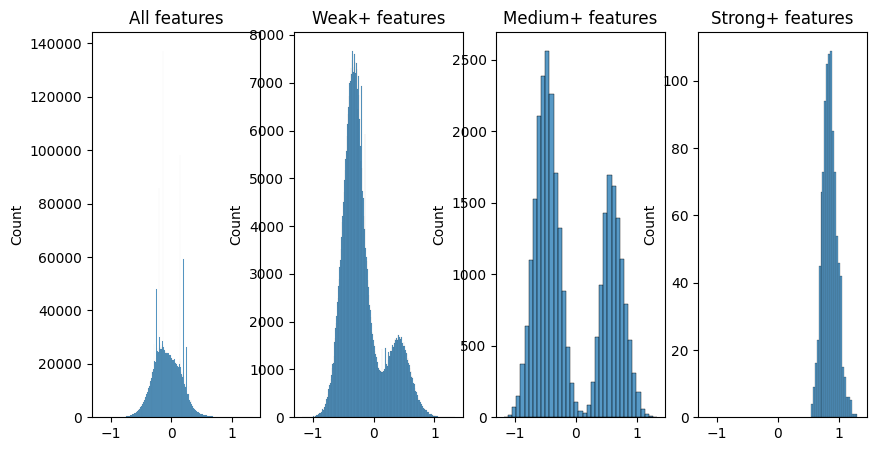

In [248]:
# 7-8 vs. 9-12
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 9-12', cons_strong_indices, cons_med_indices, cons_weak_indices)

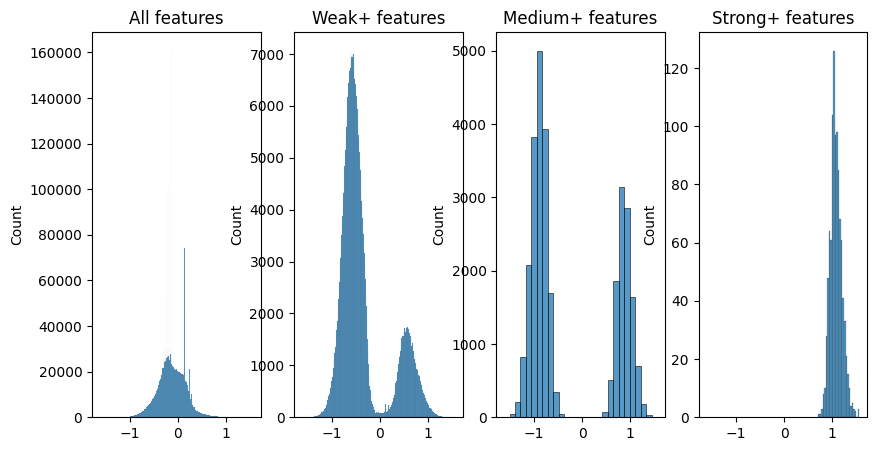

In [249]:
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 13+', cons_strong_indices, cons_med_indices, cons_weak_indices)

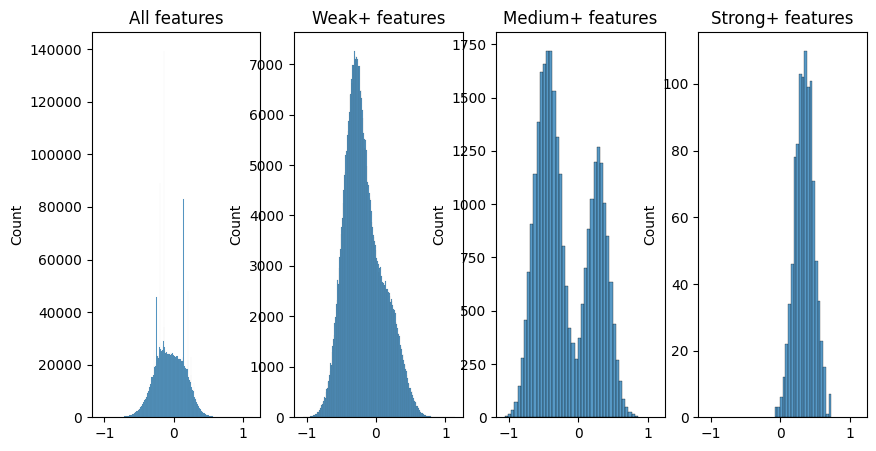

In [250]:
# 9-12 vs. 13+
plotKFAValuesDistribution(effect_sizes_per_run, '9-12 vs. 13+', cons_strong_indices, cons_med_indices, cons_weak_indices)

## Additional look at differentiating features between 7-8 and 9-12

In [251]:
chosen_comparison = '7-8 vs. 9-12'

#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeatsCustomized(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    y_1 = abs(np.nan_to_num(ef_sizes[chosen_comparison]))
    for i in index_dict:
        if y_1[i]>=meaningful_ef_size:
            sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

m_f_s_c = []
m_f_m_c= []
m_f_w_c = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        m_f_s_c.append(meaningfulFeatsCustomized(strong_es, effect_sizes_per_run[i]))
        m_f_m_c.append(meaningfulFeatsCustomized(med_es, effect_sizes_per_run[i]))
        m_f_w_c.append(meaningfulFeatsCustomized(weak_es, effect_sizes_per_run[i]))
        pbar.update(1)

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(m_f_s_c))))
f_c_s = dict(Counter(list(itertools.chain.from_iterable(m_f_s_c))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(m_f_m_c))))
f_c_m = dict(Counter(list(itertools.chain.from_iterable(m_f_m_c))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(m_f_w_c))))
f_c_w = dict(Counter(list(itertools.chain.from_iterable(m_f_w_c))))

#In how big a proportion do feats need to appear in to be considered consistant

c_s_f = [feat for feat in f_c_s if f_c_s[feat]/RUNS > CONSISTANT]
c_m_f = [feat for feat in f_c_m if f_c_m[feat]/RUNS > CONSISTANT]
c_w_f = [feat for feat in f_c_w if f_c_w[feat]/RUNS > CONSISTANT]

print("Consitently strong ef: ",c_s_f)
print("Consitently medium ef: ",c_m_f)
print("Consitently weak ef: ",c_w_f)



Calculating meaningful effects per run...: 100%|██████████| 1000/1000 [00:00<00:00, 1047.18it/s]

Strong ef size:  Counter({'AUX_Variation': 656, 'ADP_Variation': 414, 'VERB_Variation': 243, 'flat_VERB_AUX_VERB': 235, 'NestingOfClauses': 218, 'ADV_Variation': 205, 'StackingOfClauses': 186, 'NOUN_Variation': 133, 'ADJ_Variation_Corrected': 127, 'INTJ_To_SCONJ_Ratio': 125, 'flat_NOUN_PUNCT_INTJ': 99, 'PRON_Variation': 88, 'NOUN_Variation_Corrected': 88, 'NUM_Variation': 78, 'TTR': 67, 'flat_AUX_VERB_VERB': 56, 'flat_PUNCT_PROPN_CCONJ': 51, 'flat_PRON_PUNCT_CCONJ': 51, 'flat_VERB_VERB_PRON': 49, 'AUX_Variation_Corrected': 48, 'INTJ_To_PRON_Ratio': 46, 'SCONJ_Variation_Corrected': 44, 'tree_PRON_VERB_SCONJ': 39, 'PRON_Variation_Corrected': 39, 'flat_CCONJ_PRON_CCONJ': 33, 'flat_INTJ_PUNCT_NOUN': 31, 'flat_CCONJ_PRON_VERB': 27, 'tree_VERB_PRON_VERB': 25, 'SCONJ_To_ADV_Ratio': 25, 'tree_PRON_VERB_NOUN': 24, 'vocative': 21, 'ccomp': 20, 'flat_VERB_PRON_SCONJ': 20, 'csubj': 18, 'CCONJ_Variation': 17, 'PROPN_To_ADP_Ratio': 17, 'INTJ_To_AUX_Ratio': 17, 'INTJ_To_ADV_Ratio': 17, 'flat_CCONJ_PR

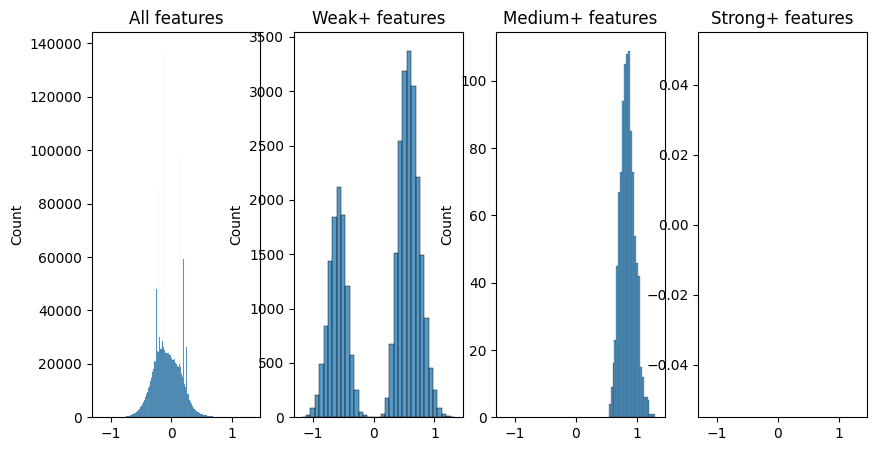

In [252]:
c_s_i = [feat_dict[feat] for feat in c_s_f]
c_m_i = [feat_dict[feat] for feat in c_m_f]
c_w_i = [feat_dict[feat] for feat in c_w_f]

plotKFAValuesDistribution(effect_sizes_per_run, chosen_comparison, c_s_i, c_m_i, c_w_i)

4810
['SCONJ_Variation_Corrected', 'StackingOfClauses', 'ADP_Variation', 'flat_INTJ_PUNCT_NOUN', 'PRON_Variation', 'NOUN_Variation_Corrected', 'nmod:gsubj', 'flat_PUNCT_PROPN_CCONJ', 'VERB_Variation', 'AUX_Variation_Corrected', 'ADV_Variation', 'flat_AUX_VERB_VERB', 'NestingOfClauses', 'flat_PROPN_CCONJ_PROPN', 'PROPN_To_ADP_Ratio', 'INTJ_To_PRON_Ratio', 'AUX_Variation', 'TTR', 'flat_PROPN_PUNCT_INTJ', 'flat_NOUN_PUNCT_INTJ', 'INTJ_To_SCONJ_Ratio', 'tree_PRON_VERB_SCONJ', 'NUM_Variation', 'ADJ_Variation_Corrected', 'flat_SCONJ_PUNCT_PUNCT', 'flat_PRON_SCONJ_AUX', 'flat_VERB_VERB_PRON', 'flat_INTJ_INTJ_ADJ', 'INTJ_To_ADP_Ratio', 'NOUN_Variation', 'flat_VERB_AUX_VERB']
31


<Axes: >

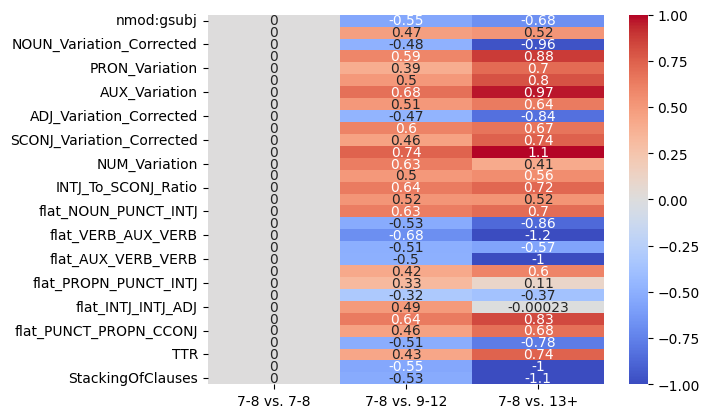

In [253]:
testing_df_2 = ef_df.copy()
print(len(testing_df_2))
#remove = ['root']
# ,
#most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
#most_important_2 = c_s_f
#most_important_2 = c_m_f
most_important_2 = c_w_f
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
print(most_important_2)
testing_df_edited_2 = testing_df_2.drop(to_drop_2)
print(len(testing_df_edited_2))
sns.heatmap(testing_df_edited_2[sub_columns(ef_df.columns, '7')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

## Additional look at differentiating features between 7-8 and 13+

In [254]:
chosen_comparison = '7-8 vs. 13+'

#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeatsCustomized(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    y_1 = abs(np.nan_to_num(ef_sizes[chosen_comparison]))
    for i in index_dict:
        if y_1[i]>=meaningful_ef_size:
            sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

m_f_s_c = []
m_f_m_c= []
m_f_w_c = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        m_f_s_c.append(meaningfulFeatsCustomized(strong_es, effect_sizes_per_run[i]))
        m_f_m_c.append(meaningfulFeatsCustomized(med_es, effect_sizes_per_run[i]))
        m_f_w_c.append(meaningfulFeatsCustomized(weak_es, effect_sizes_per_run[i]))
        pbar.update(1)

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(m_f_s_c))))
f_c_s = dict(Counter(list(itertools.chain.from_iterable(m_f_s_c))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(m_f_m_c))))
f_c_m = dict(Counter(list(itertools.chain.from_iterable(m_f_m_c))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(m_f_w_c))))
f_c_w = dict(Counter(list(itertools.chain.from_iterable(m_f_w_c))))

#In how big a proportion do feats need to appear in to be considered consistant

c_s_f = [feat for feat in f_c_s if f_c_s[feat]/RUNS > CONSISTANT]
c_m_f = [feat for feat in f_c_m if f_c_m[feat]/RUNS > CONSISTANT]
c_w_f = [feat for feat in f_c_w if f_c_w[feat]/RUNS > CONSISTANT]

print("Consitently strong ef: ",c_s_f)
print("Consitently medium ef: ",c_m_f)
print("Consitently weak ef: ",c_w_f)



Calculating meaningful effects per run...: 100%|██████████| 1000/1000 [00:01<00:00, 971.64it/s]


Strong ef size:  Counter({'AUX_Variation': 995, 'ADP_Variation': 975, 'flat_VERB_AUX_VERB': 951, 'StackingOfClauses': 946, 'NOUN_Variation_Corrected': 941, 'NestingOfClauses': 929, 'Reflex=Yes': 861, 'ccomp': 847, 'ADJ_Variation_Corrected': 831, 'VERB_Variation': 771, 'flat_AUX_VERB_VERB': 752, 'flat_PUNCT_PROPN_CCONJ': 745, 'Derivation=Ton': 726, 'flat_PRON_PUNCT': 711, 'ADV_To_SCONJ_Ratio': 703, 'ADV_Variation': 697, 'SCONJ_To_ADV_Ratio': 695, 'flat_INTJ_PUNCT_NOUN': 673, 'Number[psor]=Sing': 641, 'flat_PUNCT_PRON_INTJ': 630, 'PRON_Variation': 597, 'flat_VERB_PRON_PUNCT': 585, 'flat_SCONJ_AUX_VERB': 582, 'flat_AUX_PRON_PUNCT': 573, 'flat_PROPN_CCONJ_PROPN': 562, 'flat_AUX_AUX': 534, 'flat_SCONJ_AUX_AUX': 524, 'flat_NOUN_PUNCT_INTJ': 522, 'TTR': 500, 'tree_PRON_VERB_ADV': 498, 'SCONJ_Variation_Corrected': 488, 'Person[psor]=1': 487, 'flat_PRON_INTJ_PRON': 475, 'flat_PUNCT_SCONJ_AUX': 473, 'flat_AUX_AUX_VERB': 467, 'flat_AUX_AUX_PRON': 465, 'flat_AUX_VERB_PRON': 436, 'tree_PROPN_PROPN_

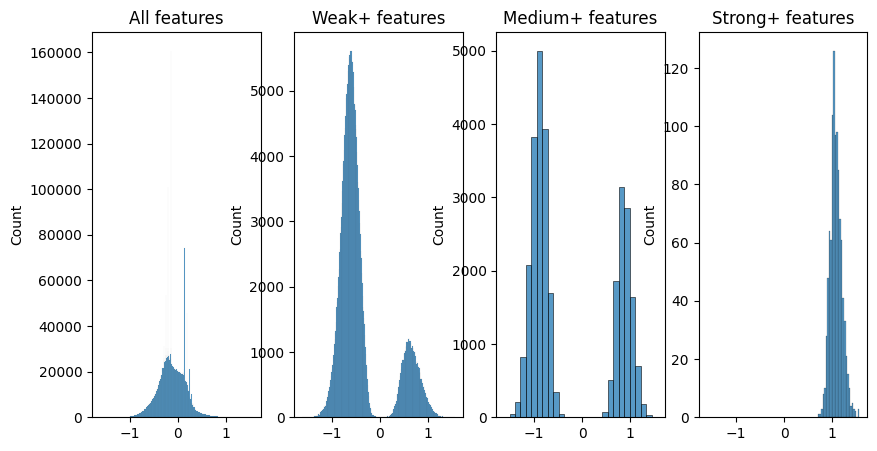

In [255]:
c_s_i = [feat_dict[feat] for feat in c_s_f]
c_m_i = [feat_dict[feat] for feat in c_m_f]
c_w_i = [feat_dict[feat] for feat in c_w_f]

plotKFAValuesDistribution(effect_sizes_per_run, chosen_comparison, c_s_i, c_m_i, c_w_i)

4810
['ADJ_Variation_Corrected', 'flat_PUNCT_PRON_INTJ', 'SCONJ_Variation_Corrected', 'StackingOfClauses', 'ADP_Variation', 'flat_AUX_PRON_PUNCT', 'flat_INTJ_PUNCT_NOUN', 'PRON_Variation', 'AUX_Variation', 'VERB_Variation', 'Number[psor]=Sing', 'TTR', 'tree_PRON_VERB_ADV', 'flat_PRON_PUNCT', 'flat_PRON_INTJ', 'flat_SCONJ_AUX_VERB', 'Reflex=Yes', 'Derivation=Ton', 'ADV_Variation', 'NOUN_Variation_Corrected', 'flat_AUX_VERB_VERB', 'NestingOfClauses', 'ccomp', 'flat_PROPN_CCONJ_PROPN', 'SCONJ_To_ADV_Ratio', 'flat_VERB_AUX_VERB', 'ADV_To_SCONJ_Ratio', 'flat_PRON_INTJ_PRON', 'flat_PUNCT_PROPN_CCONJ']
29


<Axes: >

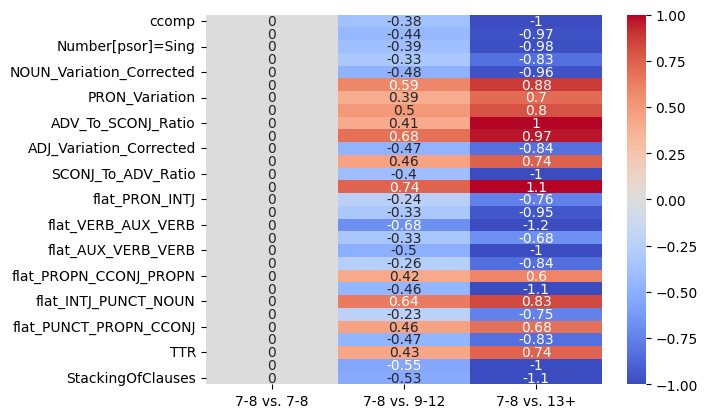

In [256]:
testing_df_2 = ef_df.copy()
print(len(testing_df_2))
#remove = ['root']
# ,
#most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
#most_important_2 = c_s_f
most_important_2 = c_m_f
#most_important_2 = c_w_f
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
print(most_important_2)
testing_df_edited_2 = testing_df_2.drop(to_drop_2)
print(len(testing_df_edited_2))
sns.heatmap(testing_df_edited_2[sub_columns(ef_df.columns, '7')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

## Additional look at differentiating features between 9-12 and 13+

In [257]:
chosen_comparison = '9-12 vs. 13+'

#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeatsCustomized(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    y_1 = abs(np.nan_to_num(ef_sizes[chosen_comparison]))
    for i in index_dict:
        if y_1[i]>=meaningful_ef_size:
            sep_between_two.append(index_dict[i])

    return list(set(sep_between_two))

m_f_s_c = []
m_f_m_c= []
m_f_w_c = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        m_f_s_c.append(meaningfulFeatsCustomized(strong_es, effect_sizes_per_run[i]))
        m_f_m_c.append(meaningfulFeatsCustomized(med_es, effect_sizes_per_run[i]))
        m_f_w_c.append(meaningfulFeatsCustomized(weak_es, effect_sizes_per_run[i]))
        pbar.update(1)

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(m_f_s_c))))
f_c_s = dict(Counter(list(itertools.chain.from_iterable(m_f_s_c))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(m_f_m_c))))
f_c_m = dict(Counter(list(itertools.chain.from_iterable(m_f_m_c))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(m_f_w_c))))
f_c_w = dict(Counter(list(itertools.chain.from_iterable(m_f_w_c))))

#In how big a proportion do feats need to appear in to be considered consistant

c_s_f = [feat for feat in f_c_s if f_c_s[feat]/RUNS > CONSISTANT]
c_m_f = [feat for feat in f_c_m if f_c_m[feat]/RUNS > CONSISTANT]
c_w_f = [feat for feat in f_c_w if f_c_w[feat]/RUNS > CONSISTANT]

print("Consitently strong ef: ",c_s_f)
print("Consitently medium ef: ",c_m_f)
print("Consitently weak ef: ",c_w_f)

Calculating meaningful effects per run...: 100%|██████████| 1000/1000 [00:00<00:00, 1046.66it/s]

Strong ef size:  Counter({'flat_PUNCT_VERB_ADJ': 131, 'flat_AUX_PRON_PUNCT': 116, 'flat_PUNCT_PRON_INTJ': 81, 'flat_PRON_INTJ': 65, 'StackingOfClauses': 41, 'flat_PUNCT_AUX_AUX': 33, 'flat_AUX_ADJ_PUNCT': 32, 'flat_ADP_PUNCT_VERB': 30, 'flat_ADP_AUX_PRON': 28, 'flat_PUNCT_AUX': 25, 'flat_AUX_AUX_ADJ': 21, 'NOUN_Variation_Corrected': 19, 'flat_PRON_INTJ_PRON': 19, 'Reflex=Yes': 19, 'tree_AUX_AUX_PUNCT': 17, 'flat_VERB_CCONJ_ADJ': 17, 'flat_AUX_AUX_PROPN': 16, 'flat_PUNCT_VERB': 15, 'Number[psor]=Sing': 14, 'flat_PROPN_ADP_AUX': 14, 'Polarity=Neg': 13, 'Person[psor]=1': 12, 'flat_ADJ_PUNCT_AUX': 11, 'flat_AUX_PRON_ADJ': 11, 'flat_VERB_AUX_PUNCT': 11, 'flat_PRON_PUNCT_AUX': 11, 'flat_PUNCT_SCONJ_AUX': 10, 'flat_AUX_AUX': 10, 'flat_SCONJ_AUX_AUX': 10, 'flat_PUNCT_AUX_VERB': 10, 'Derivation=Ton': 10, 'flat_AUX_PROPN_ADP': 10, 'flat_PROPN_CCONJ_PROPN': 9, 'flat_PUNCT_VERB_NOUN': 8, 'flat_AUX_AUX_PRON': 8, 'flat_AUX_PRON_AUX': 8, 'flat_PRON_NOUN_CCONJ': 8, 'tree_PROPN_CCONJ': 7, 'flat_PRON_PU

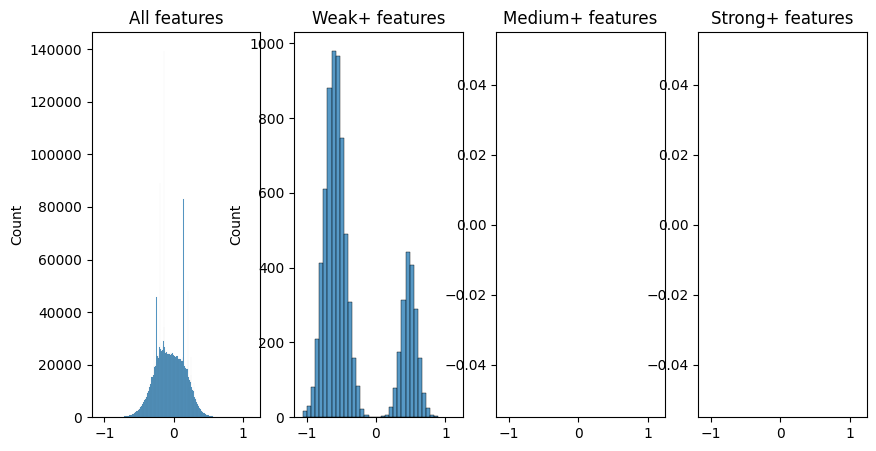

In [258]:
c_s_i = [feat_dict[feat] for feat in c_s_f]
c_m_i = [feat_dict[feat] for feat in c_m_f]
c_w_i = [feat_dict[feat] for feat in c_w_f]

plotKFAValuesDistribution(effect_sizes_per_run, chosen_comparison, c_s_i, c_m_i, c_w_i)

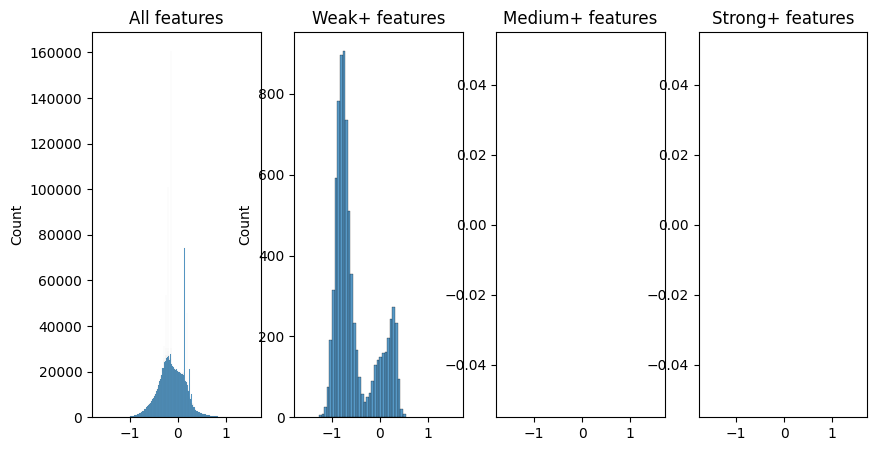

In [259]:
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 13+', c_s_i, c_m_i, c_w_i)

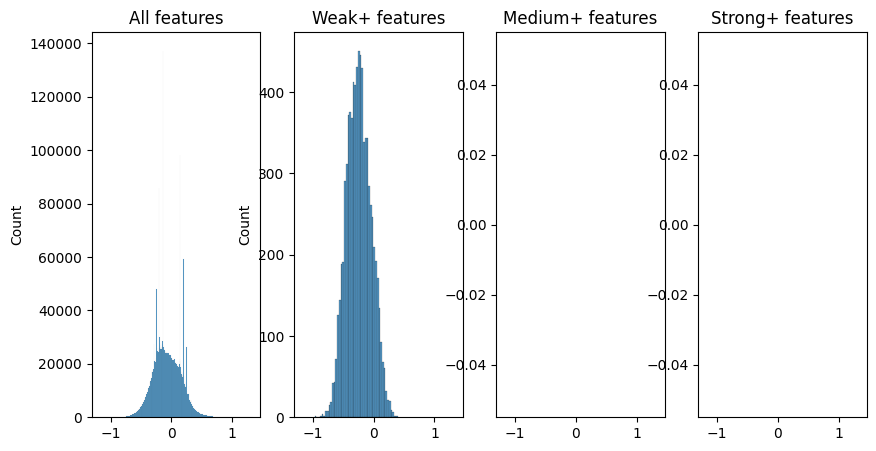

In [260]:
plotKFAValuesDistribution(effect_sizes_per_run, '7-8 vs. 9-12', c_s_i, c_m_i, c_w_i)

4810
['flat_PUNCT_VERB_ADJ', 'tree_AUX_AUX_PUNCT', 'flat_ADP_ADV_SCONJ', 'flat_PROPN_AUX_NUM', 'flat_PUNCT_PRON_INTJ', 'flat_PRON_INTJ', 'flat_PRON_INTJ_PRON', 'flat_AUX_PRON_PUNCT']
8


<Axes: >

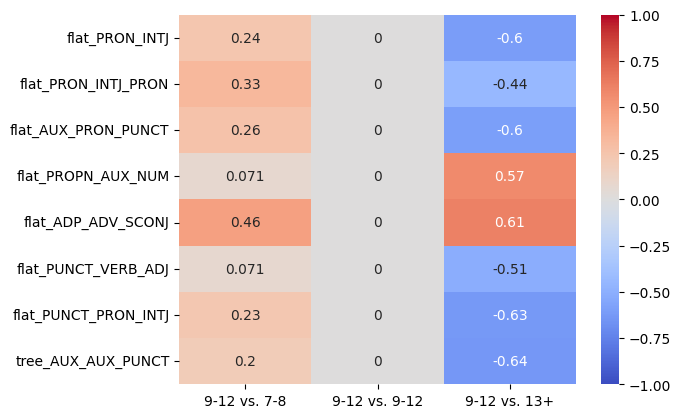

In [261]:
testing_df_2 = ef_df.copy()
print(len(testing_df_2))
#remove = ['root']
# ,
#most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
#most_important_2 = c_s_f
#most_important_2 = c_m_f
most_important_2 = c_w_f
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
print(most_important_2)
testing_df_edited_2 = testing_df_2.drop(to_drop_2)
print(len(testing_df_edited_2))
sns.heatmap(testing_df_edited_2[sub_columns(ef_df.columns, '9')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

## Other tests

### Checking if my TTR calculations work (they do, jsut some rounding mishaps)

In [262]:
def testTTR(corpus: dict):
    returnable = {}
    for id in corpus:
        df = corpus[id]
        types = len(df.drop_duplicates(['text'])['text'])
        tokens = len(df)
        returnable[id] = (types/tokens)
    return returnable


In [263]:
new_func = testTTR(corpus)

In [264]:
old_func = bdf.getTypeTokenRatios(bdf.getWordFrequencies(corpus), bdf.getTokenAmounts(corpus))

In [265]:
young = []
mid = []
old = []
for id in new_func:
    if old_func[id] != new_func[id]:
        print("Different!")
        print(id)
        print(old_func[id])
        print(new_func[id])

Different!
9789511269830_7_3
0.3797716370515506
0.3798392000540504
Different!
9789510487570_9_1
0.18924734464656331
0.18926260529849837
Different!
9789526308623_14_3
0.23398835516739447
0.23404900533721495
Different!
9789520454371_9_2
0.4034324241495556
0.4034630707937481


### Cosine similarities between the means of KFA results (very messy, stay away if you can :D)

In [266]:
windows = ['7','9','1']
def sub_columns_expanded(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [267]:
weak_7to9 = ['vocative', 'CCONJ_PRON_CCONJ', 'PROPN_To_ADP_Ratio', 'xcomp:ds_xcomp:ds', 'acl:relcl_ccomp', 'nmod_acl:relcl', 'obl_nmod:gsubj', 'Reflex=Yes', 'PUNCT_PROPN_CCONJ', 'NOUN_PUNCT_INTJ', 'PRON_AUX_ADP', 'vocative_amod', 'INTJ_To_AUX_Ratio', 'VERB_VERB_PRON', 'INTJ_PUNCT_NOUN', 'PRON_SCONJ', 'acl:relcl_xcomp:ds', 'SCONJ_VERB', 'xcomp_xcomp', 'ccomp', 'xcomp:ds_advcl', 'advmod_xcomp:ds', 'obl_ccomp', 'TTR', 'ADP_ADV_SCONJ', 'ADV_To_SCONJ_Ratio', 'PRON_NOUN_VERB', 'nmod:gsubj', 'root_vocative', 'INTJ_To_SCONJ_Ratio', 'VERB_AUX_VERB', 'PRON_SCONJ_AUX', 'INTJ_To_PRON_Ratio', 'SCONJ_To_ADV_Ratio', 'INTJ_INTJ_ADJ', 'SCONJ_PUNCT_PUNCT', 'PROPN_CCONJ_PROPN', 'Case=Abl', 'AUX_VERB_VERB', 'PRON_PUNCT_CCONJ', 'ccomp_cc', 'VERB_SCONJ_AUX', 'PROPN_PUNCT_INTJ', 'xcomp:ds_ccomp', 'Derivation=Ton', 'INTJ_To_ADV_Ratio', 'InfForm=3', 'INTJ_To_CCONJ_Ratio', 'VERB_PRON_SCONJ', 'INTJ_To_ADP_Ratio', 'VERB_PUNCT_NOUN']
weak_9to13 = ['Number[psor]=Sing', 'flat:name_obj', 'PROPN_AUX_NUM', 'flat:name_flat:foreign', 'PUNCT_VERB', 'flat:name_aux', 'AUX_AUX_PROPN', 'PRON_INTJ', 'ADP_AUX_PRON', 'VERB_AUX_PUNCT', 'Polarity=Neg', 'AUX_PRON_PUNCT', 'PUNCT_VERB_ADJ', 'AUX_AUX_ADJ', 'PUNCT_PRON_INTJ', 'PRON_PUNCT_AUX', 'ADP_ADV_SCONJ', 'VERB_CCONJ_ADJ', 'SCONJ_SCONJ_AUX', 'AUX_PRON_ADJ', 'PUNCT_AUX_AUX', 'PUNCT_AUX', 'PRON_NOUN_CCONJ', 'AUX_PROPN_ADP', 'ADP_AUX_SCONJ', 'PRON_INTJ_PRON', 'ADP_PUNCT_VERB', 'AUX_ADJ_PUNCT']
med_7to13 = ['PRON_NOUN', 'VERB_PRON', 'ccomp_advcl', 'AUX_AUX_VERB', 'PUNCT_SCONJ_AUX', 'Number[psor]=Sing', 'PRON_CCONJ', 'PRON_PRON_PUNCT', 'ADV_To_AUX_Ratio', 'SCONJ_AUX', 'Person=1', 'PRON_CCONJ_PRON', 'acl:relcl_xcomp', 'ccomp_nmod', 'appos_ccomp', 'Reflex=Yes', 'PUNCT_PROPN_CCONJ', 'NOUN_PUNCT_INTJ', 'PRON_PUNCT_SCONJ', 'PUNCT_VERB_PRON', 'AUX_AUX', 'root_ccomp', 'PROPN_VERB_PUNCT', 'PRON_INTJ', 'Derivation=Vs', 'ccomp_amod', 'INTJ_PUNCT_NOUN', 'VERB_VERB_PRON', 'PRON_PUNCT', 'PRON_PUNCT_ADV', 'AUX_To_ADV_Ratio', 'VERB_AUX', 'Polarity=Neg', 'SCONJ_VERB', 'ccomp_xcomp:ds', 'ccomp_nsubj:cop', 'ccomp', 'AUX_VERB_PRON', 'PUNCT_NOUN_PROPN', 'PROPN_To_AUX_Ratio', 'Connegative=Yes', 'AUX_PRON_PUNCT', 'ccomp_obl', 'PUNCT_SCONJ_VERB', 'ADV_VERB_AUX', 'nmod_ccomp', 'conj_aux', 'PUNCT_PRON_INTJ', 'ccomp_mark', 'obl_ccomp', 'CCONJ_AUX', 'PRON_PUNCT_AUX', 'TTR', 'ADV_To_SCONJ_Ratio', 'SCONJ_AUX_ADJ', 'Derivation=Llinen', 'ccomp_cop', 'INTJ_To_SCONJ_Ratio', 'SCONJ_VERB_PRON', 'VERB_AUX_VERB', 'AUX_AUX_PRON', 'CCONJ_AUX_VERB', 'SCONJ_To_ADV_Ratio', 'ccomp_conj', 'ccomp_xcomp', 'Person[psor]=1', 'SCONJ_AUX_ADV', 'ccomp_aux', 'ccomp_advmod', 'PROPN_CCONJ_PROPN', 'SCONJ_AUX_AUX', 'AUX_VERB_VERB', 'NOUN_PRON_PUNCT', 'PROPN_CCONJ', 'PRON_PUNCT_CCONJ', 'PRON_AUX_AUX', 'PRON_PUNCT_PRON', 'PRON_PUNCT_VERB', 'PROPN_To_SCONJ_Ratio', 'xcomp:ds_ccomp', 'AUX_AUX_AUX', 'Derivation=Ton', 'conj_ccomp', 'ccomp_obj', 'parataxis_nsubj', 'VERB_PRON_PUNCT', 'aux', 'SCONJ_AUX_VERB', 'VERB_PRON_CCONJ', 'PRON_INTJ_PRON', 'nsubj_ccomp', 'nmod_acl:relcl']
med_7to9 = ['VERB_AUX_VERB']
comb = list(set(med_7to13))

In [268]:
testing_df_2 = ef_df.copy()
most_important_2 = comb
to_drop_2 = [x for x in index_dict.values() if x not in most_important_2]
print(most_important_2)
testing_df_edited_2 = testing_df_2.drop(to_drop_2)

['PRON_PUNCT_SCONJ', 'VERB_AUX', 'PRON_PRON_PUNCT', 'PRON_PUNCT_PRON', 'INTJ_To_SCONJ_Ratio', 'PROPN_VERB_PUNCT', 'PRON_PUNCT_ADV', 'PRON_PUNCT_CCONJ', 'Polarity=Neg', 'NOUN_PRON_PUNCT', 'PUNCT_PRON_INTJ', 'VERB_VERB_PRON', 'AUX_AUX_PRON', 'TTR', 'parataxis_nsubj', 'conj_aux', 'conj_ccomp', 'PROPN_To_SCONJ_Ratio', 'ccomp_aux', 'PRON_PUNCT_AUX', 'PROPN_To_AUX_Ratio', 'ADV_To_AUX_Ratio', 'VERB_PRON_CCONJ', 'SCONJ_AUX_ADJ', 'ccomp_nsubj:cop', 'Derivation=Vs', 'AUX_AUX', 'PUNCT_NOUN_PROPN', 'ccomp_xcomp:ds', 'SCONJ_AUX_AUX', 'AUX_AUX_AUX', 'PRON_CCONJ', 'PRON_INTJ_PRON', 'Person[psor]=1', 'ccomp_advcl', 'AUX_To_ADV_Ratio', 'Person=1', 'root_ccomp', 'PRON_NOUN', 'ccomp_amod', 'appos_ccomp', 'xcomp:ds_ccomp', 'SCONJ_VERB', 'ccomp_obj', 'ccomp_conj', 'PUNCT_SCONJ_VERB', 'VERB_PRON_PUNCT', 'PRON_INTJ', 'AUX_PRON_PUNCT', 'PUNCT_SCONJ_AUX', 'CCONJ_AUX_VERB', 'PRON_AUX_AUX', 'VERB_AUX_VERB', 'ccomp_nmod', 'SCONJ_To_ADV_Ratio', 'AUX_VERB_VERB', 'ADV_VERB_AUX', 'NOUN_PUNCT_INTJ', 'Derivation=Llinen

In [269]:
temp_1_df = testing_df_edited_2.copy()
prep_for_cossim = {}
for window in windows:
    prep_for_cossim[window] = temp_1_df[sub_columns(temp_1_df.columns, window)].to_numpy(na_value=0.0)

In [270]:
from sklearn.metrics.pairwise import cosine_similarity
sim_scores = {}
for key1 in prep_for_cossim:
    scores = []
    for key2 in prep_for_cossim:
        scores.append(cosine_similarity(prep_for_cossim[key1], prep_for_cossim[key2]))
    sim_scores[key1] = scores

In [271]:
#Create df
matrix_df = pd.DataFrame.from_dict(sim_scores, orient='index').transpose()
#Set indexes correctly
matrix_df.index = prep_for_cossim.keys()
#Dig out the values from nd.array
matrix_df_2 = matrix_df.copy().applymap(lambda x: x[0][0])

<Axes: >

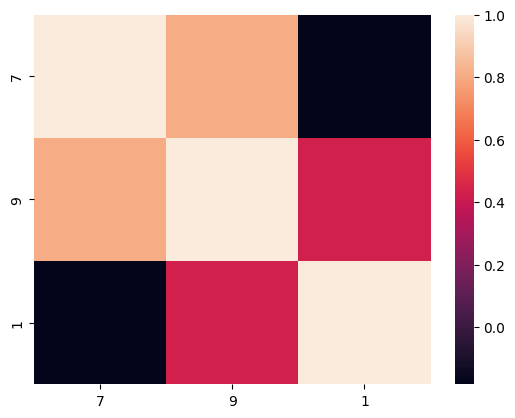

In [272]:
sns.heatmap(matrix_df_2)